# STA365 Homework 9

## Question 1: Copulas

2. Repeat the exercise using instead a two pass approach in the manner of https://www.pymc.io/projects/examples/en/latest/howto/copula-estimation.html

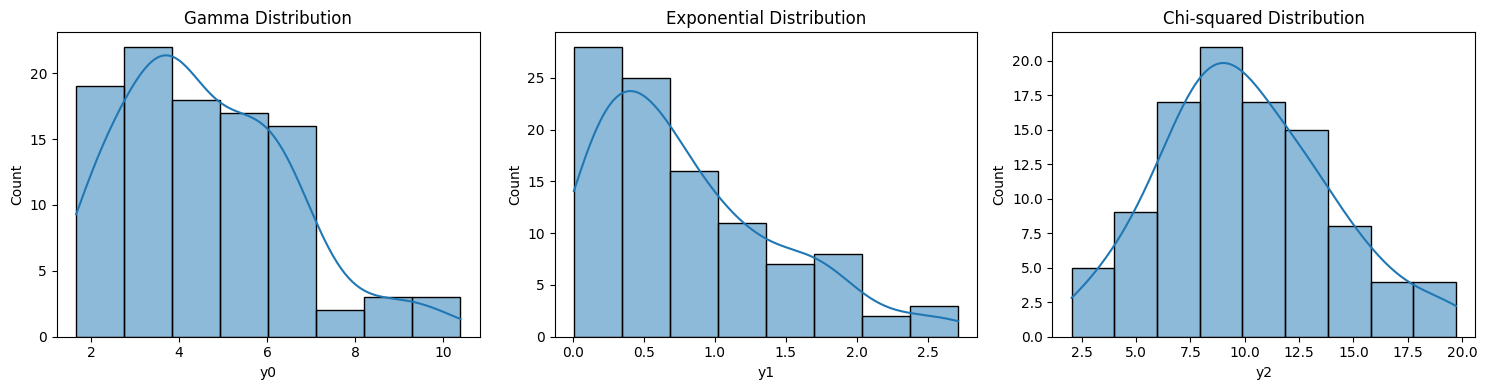

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p1]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


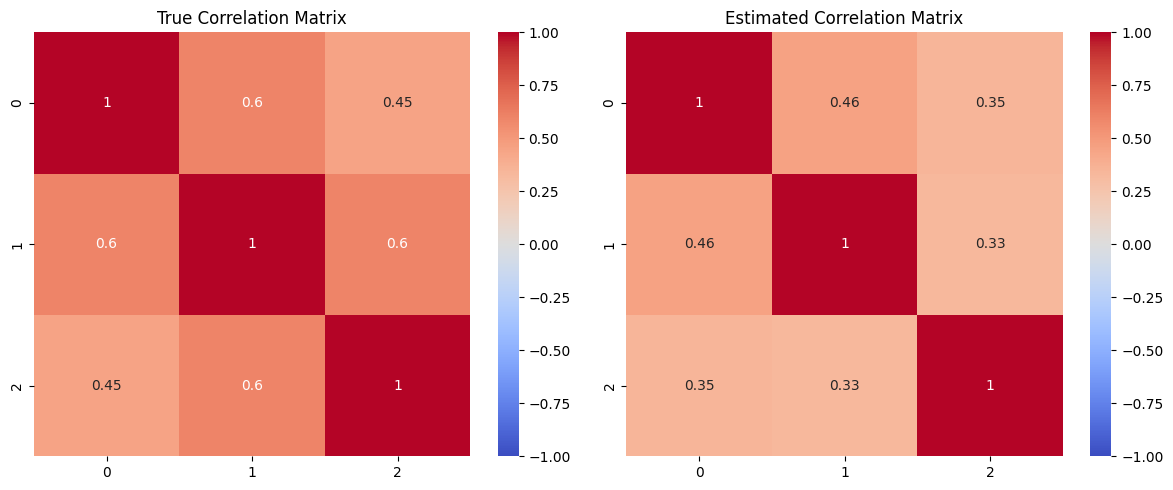

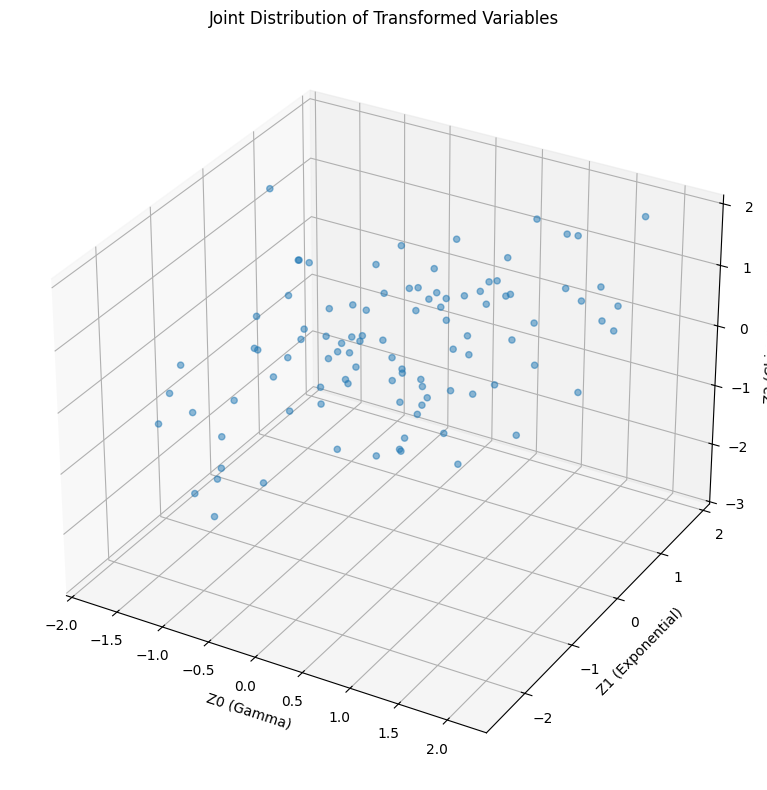

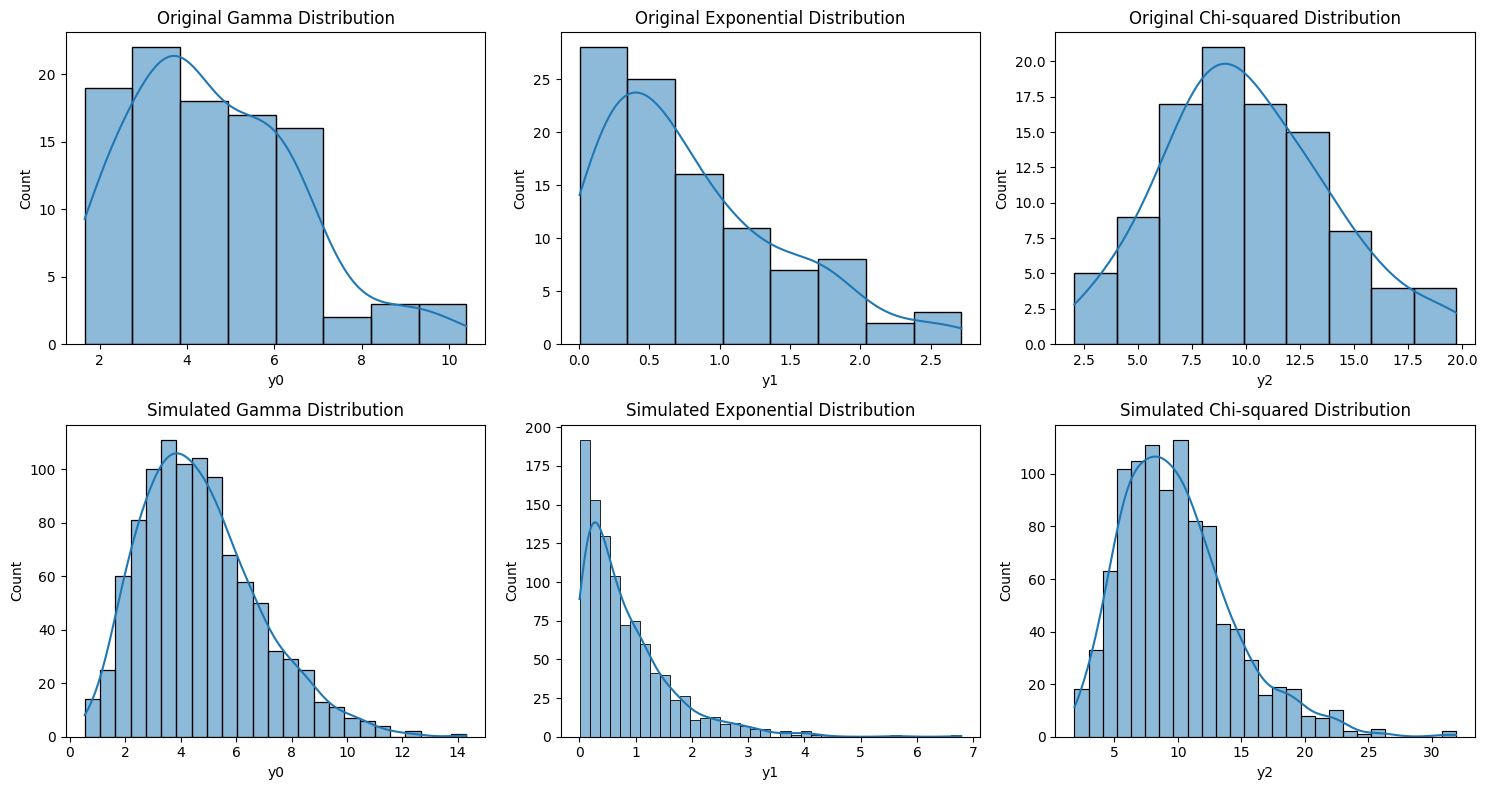

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import pymc as pm
import arviz as az

# Generating synthetic data with known dependence structure
np.random.seed(42)  # Set seed for reproducibility
p = 3  # Number of variables
# Define correlation matrix (with moderate correlation)
a_cor = (np.ones((p, p)) * 0.6 + np.eye(p) * 0.4)
a_cor[0, -1] = a_cor[-1, 0] = 0.45  # Lower correlation between first and last variables

n = 100  # Sample size
# Generate multivariate normal data with the specified correlation
x = stats.multivariate_normal(mean=np.zeros(p), cov=a_cor).rvs(size=n)

# Transform to non-normal marginals using inverse CDF method
y = x.copy()
y[:, 0] = stats.gamma(a=5).ppf(stats.norm().cdf(x[:, 0]))  # Gamma distribution
y[:, 1] = stats.expon(scale=1).ppf(stats.norm().cdf(x[:, 1]))  # Exponential distribution
y[:, 2] = stats.chi2(df=10).ppf(stats.norm().cdf(x[:, 2]))  # Chi-squared distribution

# Create a DataFrame for visualization
df = pd.DataFrame(y, columns=['y0', 'y1', 'y2'])

# Plot the marginal distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(df['y0'], kde=True, ax=axes[0])
axes[0].set_title('Gamma Distribution')
sns.histplot(df['y1'], kde=True, ax=axes[1])
axes[1].set_title('Exponential Distribution')
sns.histplot(df['y2'], kde=True, ax=axes[2])
axes[2].set_title('Chi-squared Distribution')
plt.tight_layout()
plt.show()

# =============================================
# TWO-PASS APPROACH FOR COPULA ESTIMATION
# =============================================

# FIRST PASS: Estimate the marginal distributions
marginal_models = []
u_values = []  # To store the transformed values

# For y0 (Gamma)
with pm.Model() as model_y0:
    p0 = pm.HalfNormal('p0', sigma=10)
    y0_obs = pm.Gamma('y0_obs', alpha=p0, beta=1, observed=y[:, 0])
    trace_y0 = pm.sample(1000, tune=1000, return_inferencedata=True)
    
marginal_models.append(trace_y0)

# Calculate the empirical CDF values (probability integral transform)
p0_mean = trace_y0.posterior['p0'].mean().values
u0 = stats.gamma.cdf(y[:, 0], a=p0_mean, scale=1)
u_values.append(u0)

# For y1 (Exponential)
with pm.Model() as model_y1:
    p1 = pm.HalfNormal('p1', sigma=10)
    y1_obs = pm.Exponential('y1_obs', lam=p1, observed=y[:, 1])
    trace_y1 = pm.sample(1000, tune=1000, return_inferencedata=True)
    
marginal_models.append(trace_y1)

# Calculate the empirical CDF values
p1_mean = trace_y1.posterior['p1'].mean().values
u1 = stats.expon.cdf(y[:, 1], scale=1/p1_mean)
u_values.append(u1)

# For y2 (Chi-squared)
with pm.Model() as model_y2:
    p2 = pm.HalfNormal('p2', sigma=10)
    y2_obs = pm.ChiSquared('y2_obs', nu=p2, observed=y[:, 2])
    trace_y2 = pm.sample(1000, tune=1000, return_inferencedata=True)
    
marginal_models.append(trace_y2)

# Calculate the empirical CDF values
p2_mean = trace_y2.posterior['p2'].mean().values
u2 = stats.chi2.cdf(y[:, 2], df=p2_mean)
u_values.append(u2)

# Transform uniform probabilities to normal scores
z_values = np.column_stack([
    stats.norm.ppf(u0),
    stats.norm.ppf(u1),
    stats.norm.ppf(u2)
])

# SECOND PASS: Estimate the dependence structure (correlation matrix)
with pm.Model() as copula_model:
    # LKJ prior on the correlation matrix
    chol, corr, stds = pm.LKJCholeskyCov('chol', n=p, eta=2.0,
                                          sd_dist=pm.Exponential.dist(1.0, shape=p),
                                          compute_corr=True)
    
    # Likelihood of the transformed data
    obs = pm.MvNormal('obs', mu=np.zeros(p), chol=chol, observed=z_values)
    
    # Sample from the posterior
    trace_copula = pm.sample(1000, tune=1000, return_inferencedata=True)

# Extract the correlation matrix - access via 'chol_corr' instead of 'corr'
corr_samples = trace_copula.posterior['chol_corr'].values
mean_corr = corr_samples.mean(axis=(0, 1))
mean_corr_matrix = mean_corr

# Compare the estimated correlation to the true correlation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(a_cor, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('True Correlation Matrix')
sns.heatmap(mean_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('Estimated Correlation Matrix')
plt.tight_layout()
plt.show()

# Plot the joint distribution of the transformed variables
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_values[:, 0], z_values[:, 1], z_values[:, 2], alpha=0.5)
ax.set_xlabel('Z0 (Gamma)')
ax.set_ylabel('Z1 (Exponential)')
ax.set_zlabel('Z2 (Chi-squared)')
ax.set_title('Joint Distribution of Transformed Variables')
plt.tight_layout()
plt.show()

# Simulate from the fitted copula to generate new data
def simulate_from_copula(n_samples=100):
    # Get parameter estimates
    p0_mean = trace_y0.posterior['p0'].mean().values
    p1_mean = trace_y1.posterior['p1'].mean().values
    p2_mean = trace_y2.posterior['p2'].mean().values
    
    # Sample a random correlation matrix from the posterior
    idx = np.random.randint(0, corr_samples.shape[0])
    jdx = np.random.randint(0, corr_samples.shape[1])
    corr_matrix = corr_samples[idx, jdx]
    
    # Generate multivariate normal data with the sampled correlation
    z_sim = stats.multivariate_normal(mean=np.zeros(p), cov=corr_matrix).rvs(n_samples)
    
    # Transform back to original scales using inverse CDF
    y_sim = np.zeros((n_samples, p))
    y_sim[:, 0] = stats.gamma.ppf(stats.norm.cdf(z_sim[:, 0]), a=p0_mean, scale=1)
    y_sim[:, 1] = stats.expon.ppf(stats.norm.cdf(z_sim[:, 1]), scale=1/p1_mean)
    y_sim[:, 2] = stats.chi2.ppf(stats.norm.cdf(z_sim[:, 2]), df=p2_mean)
    
    return y_sim

# Generate simulated data
sim_data = simulate_from_copula(n_samples=1000)
sim_df = pd.DataFrame(sim_data, columns=['y0', 'y1', 'y2'])

# Compare original and simulated distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# Original data
sns.histplot(df['y0'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Original Gamma Distribution')
sns.histplot(df['y1'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Original Exponential Distribution')
sns.histplot(df['y2'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Original Chi-squared Distribution')

# Simulated data
sns.histplot(sim_df['y0'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Simulated Gamma Distribution')
sns.histplot(sim_df['y1'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Simulated Exponential Distribution')
sns.histplot(sim_df['y2'], kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Simulated Chi-squared Distribution')

plt.tight_layout()
plt.show()

### 3. Describe what a copula is and how the two verions of code implement it 


A **copula** is a mathematical function that describes the dependency structure between random variables, independent of their individual marginal distributions. More formally, a copula is a multivariate distribution function with uniform marginals on the interval [0,1].

Sklar's theorem states that any multivariate distribution can be decomposed into:
1. Its marginal distributions (which describe each variable individually)
2. A copula (which describes the dependency structure between the variables)

Mathematically, for a multivariate distribution function $F$ with marginals $F_1, F_2, ..., F_n$, there exists a copula $C$ such that:

$$F(x_1, x_2, ..., x_n) = C(F_1(x_1), F_2(x_2), ..., F_n(x_n))$$

The Two Approaches to Copula Modeling

#### Approach 1: Joint Estimation (Original Code)

The first approach implements what we could call a "joint estimation" method, where:

1. We model the marginal distributions and the copula structure simultaneously
2. We use PyMC's Potential function to combine the marginal likelihoods with the multivariate normal copula

Key components:
- Marginal distributions (Gamma, Exponential, Chi-squared) with respective parameters
- Transformations to normal scores via probability integral transform
- LKJ prior on the correlation matrix for the multivariate normal copula
- A potential function that evaluates the likelihood of the transformed observations under the multivariate normal distribution

This approach is more computationally intensive as it estimates all parameters simultaneously, but can potentially capture parameter uncertainty better.

#### Approach 2: Two-Pass Estimation

The second approach follows a sequential process:

1. **First Pass**: Estimate each marginal distribution separately
   - Fit Gamma, Exponential, and Chi-squared distributions to their respective variables
   - Transform observations to uniform space using the estimated CDFs
   - Convert to normal scores using the inverse CDF of the normal distribution

2. **Second Pass**: Estimate the dependence structure
   - Using the transformed normal scores from the first step
   - Apply an LKJ prior on the correlation matrix
   - Fit a multivariate normal distribution to capture dependencies

This approach is often more computationally stable and efficient, as each step involves simpler models. However, it doesn't propagate uncertainty from the first step to the second.

#### Differences Between the Two Implementations

1. **Parameter Uncertainty Propagation**:
   - Joint approach: Automatically handles uncertainty in marginal parameters when estimating the correlation
   - Two-pass approach: Uses point estimates of marginal parameters when estimating the correlation

2. **Computational Efficiency**:
   - Joint approach: More computationally intensive, potentially slower convergence
   - Two-pass approach: More efficient and often has better convergence properties

3. **Implementation Complexity**:
   - Joint approach: More complex to implement, requires defining custom potential functions
   - Two-pass approach: Simpler to implement and understand

### 4. Describe how to use this to create arbitary multivariate GLM regression

To extend copulas for arbitrary multivariate generalized linear model (GLM) regressions:

1. **Model each marginal as a GLM**:
   - For each variable, define an appropriate link function and error distribution
   - For example, for count data, use Poisson regression; for binary data, use logistic regression
   - Include relevant predictors/covariates for each marginal model

2. **Transform fitted values to normal scores**:
   - Compute the CDF of each fitted GLM model at observed data points
   - Transform these uniform probabilities to normal scores

3. **Model dependency with a copula**:
   - Use a multivariate normal (Gaussian) copula to model the dependency structure
   - Instead of a constant correlation matrix, you can model correlation as a function of predictors

4. **Prediction and simulation**:
   - To generate new data, first simulate from the multivariate normal distribution
   - Transform these normal scores back to uniform probabilities
   - Use the inverse CDF of each GLM to transform back to the original scale

## Question 2: Variable Selection using Spike and Slab

Perform multivarite regression (or multivariate probit classification) with spike and slab variable selection priors and compare inference to analagous inference with diffuse normal priors (imposing minimal L2 style regularization on the likelihood).

You may artificially limit the size of your data to reduce the computational demands, but if you do so, discuss the behavior of the computational demands with respect to the number of observations $n$, the number of random variables $m$ making up the multivariate observations, and the number of columns of the design matrix $p$.

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma, tau, lambda, beta]
>BinaryGibbsMetropolis: [gamma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
/Users/yiru/Library/Python/3.12/lib/python/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 306 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [y]


Output()

Sampling: [y]


Output()

ValueError: Can not extract posterior from Inference data with groups:
	> posterior_predictive
	> observed_data! See /Users/yiru/Library/Python/3.12/lib/python/site-packages/arviz/data/converters.py for other conversion utilities.

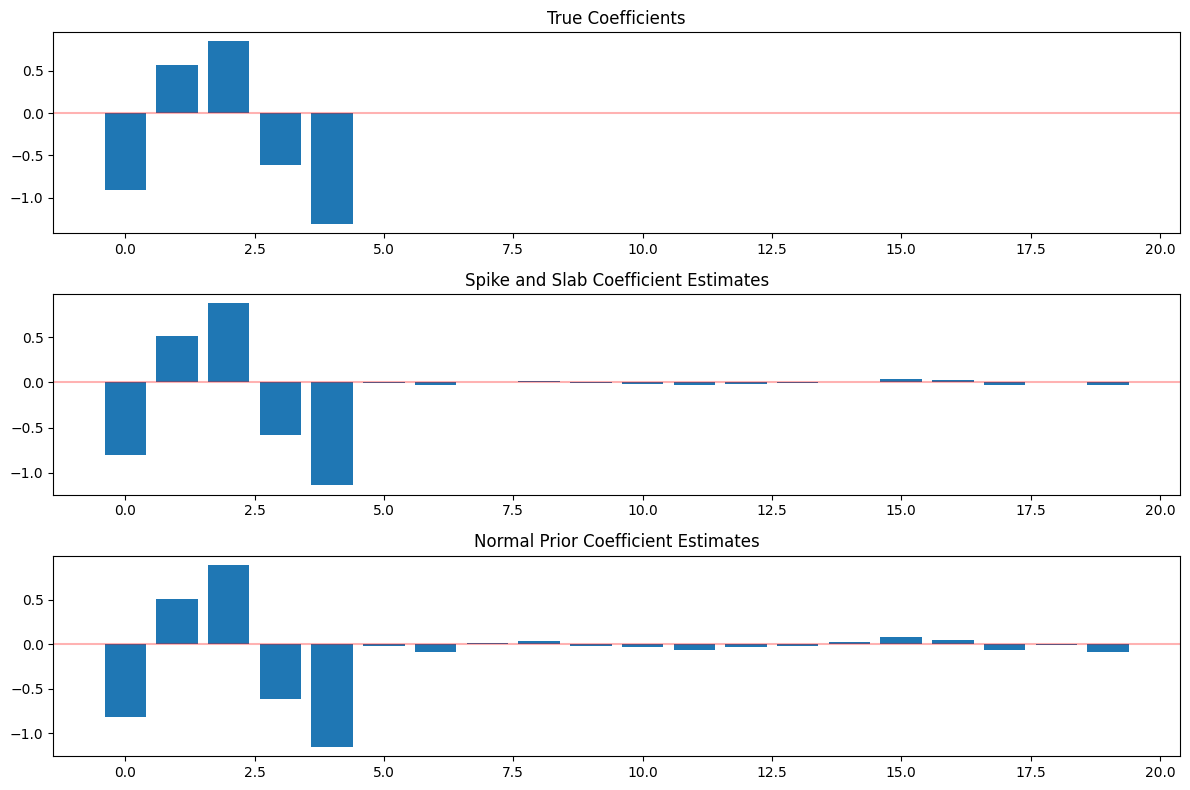

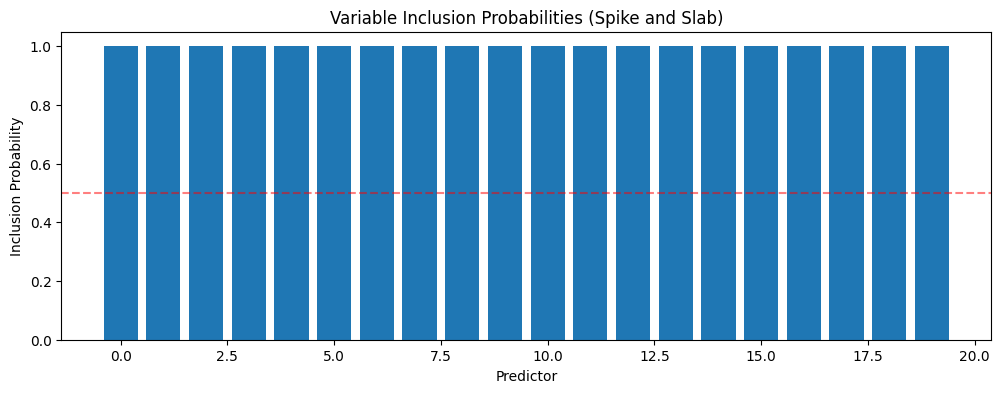

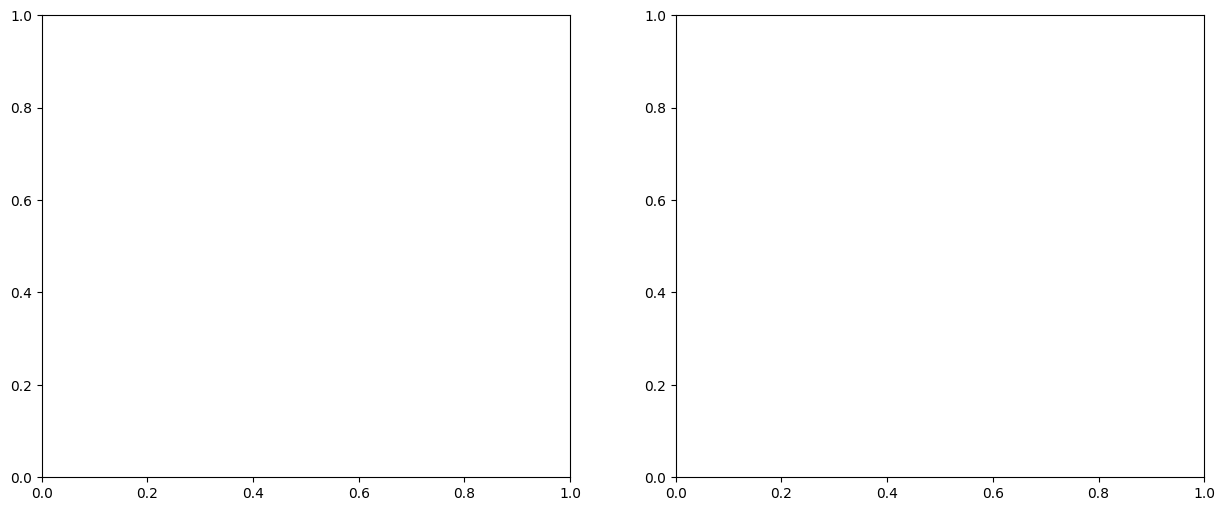

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Data dimensions
n = 100  # number of observations
p = 20   # number of predictors
k = 5    # number of true predictors

# Generate predictors
X = np.random.normal(0, 1, size=(n, p))

# Generate sparse coefficients (only k are non-zero)
true_beta = np.zeros(p)
true_beta[:k] = np.random.uniform(0.5, 1.5, size=k) * np.random.choice([-1, 1], size=k)

# Generate response with noise
sigma = 0.5
y = X @ true_beta + np.random.normal(0, sigma, size=n)

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def fit_spike_and_slab_model(X, y, chains=2, draws=1000):
    with pm.Model() as spike_slab_model:
        # Priors
        sigma = pm.HalfNormal("sigma", sigma=1)
        
        # Spike and slab prior components
        tau = pm.HalfCauchy("tau", beta=1)  # Global scale for the slab
        
        # Binary indicators for variable inclusion
        gamma = pm.Bernoulli("gamma", p=0.5, shape=X.shape[1])
        
        # Local scales
        lambda_ = pm.HalfCauchy("lambda", beta=1, shape=X.shape[1])
        
        # Coefficients with spike and slab prior
        beta = pm.Normal("beta", 
                         mu=0, 
                         sigma=tau * lambda_ * gamma, 
                         shape=X.shape[1])
        
        # Expected value of outcome
        mu = pm.math.dot(X, beta)
        
        # Likelihood
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
        
        # MCMC sampling
        trace_ss = pm.sample(draws=draws, chains=chains, return_inferencedata=True)
        
    return trace_ss, spike_slab_model

def fit_normal_prior_model(X, y, chains=2, draws=1000):
    with pm.Model() as normal_prior_model:
        # Priors
        sigma = pm.HalfNormal("sigma", sigma=1)
        
        # Diffuse normal priors for coefficients
        beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
        
        # Expected value of outcome
        mu = pm.math.dot(X, beta)
        
        # Likelihood
        likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)
        
        # MCMC sampling
        trace_normal = pm.sample(draws=draws, chains=chains, return_inferencedata=True)
        
    return trace_normal, normal_prior_model

# Fit both models
trace_ss, spike_slab_model = fit_spike_and_slab_model(X_scaled, y)
trace_normal, normal_prior_model = fit_normal_prior_model(X_scaled, y)

# Extract coefficient posteriors
beta_ss = trace_ss.posterior['beta'].mean(dim=["chain", "draw"]).values
beta_normal = trace_normal.posterior['beta'].mean(dim=["chain", "draw"]).values

# Inclusion probabilities for spike and slab
inclusion_prob = trace_ss.posterior['gamma'].mean(dim=["chain", "draw"]).values

# Create comparison dataframe
coef_comparison = pd.DataFrame({
    'True Beta': true_beta,
    'Spike-Slab Beta': beta_ss,
    'Normal Prior Beta': beta_normal,
    'Inclusion Probability': inclusion_prob
})

# Sort by inclusion probability
coef_comparison = coef_comparison.sort_values('Inclusion Probability', ascending=False)

# Create visual comparison of coefficient estimates
plt.figure(figsize=(12, 8))

# Plot true coefficients
plt.subplot(3, 1, 1)
plt.bar(range(p), true_beta)
plt.title('True Coefficients')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

# Plot spike and slab estimates
plt.subplot(3, 1, 2)
plt.bar(range(p), beta_ss)
plt.title('Spike and Slab Coefficient Estimates')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

# Plot normal prior estimates
plt.subplot(3, 1, 3)
plt.bar(range(p), beta_normal)
plt.title('Normal Prior Coefficient Estimates')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

plt.tight_layout()

# Plot inclusion probabilities for spike and slab
plt.figure(figsize=(12, 4))
plt.bar(range(p), inclusion_prob)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
plt.title('Variable Inclusion Probabilities (Spike and Slab)')
plt.xlabel('Predictor')
plt.ylabel('Inclusion Probability')

# Posterior predictive checks for both models
with spike_slab_model:
    ppc_ss = pm.sample_posterior_predictive(trace_ss)

with normal_prior_model:
    ppc_normal = pm.sample_posterior_predictive(trace_normal)

# Plot posterior predictive distributions
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Spike and slab
    
az.plot_trace(ppc_ss, var_names='p');
ax[0].set_title('Posterior Predictive Check (Spike and Slab)')

# Normal prior
az.plot_ppc(az.from_pymc(ppc=ppc_normal, posterior=trace_normal), ax=ax[1])
ax[1].set_title('Posterior Predictive Check (Normal Prior)')

### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



### Q3 Variable Selection

Perform multivarite regression (or multivariate probit classification) with the horseshoe variable selection prior and compare inference to analagous inference with spike and slab priors.

The horseshoe variable selection prior is introduced here
- https://www.pymc.io/projects/docs/en/v5.6.0/learn/core_notebooks/pymc_overview.html
- and searches for "horseshoe prior pymc" on google produce additional examples



True sparse coefficients:
[6.60098441 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Number of non-zero coefficients: 1
Indices of informative features: [ 0 17 15  1]


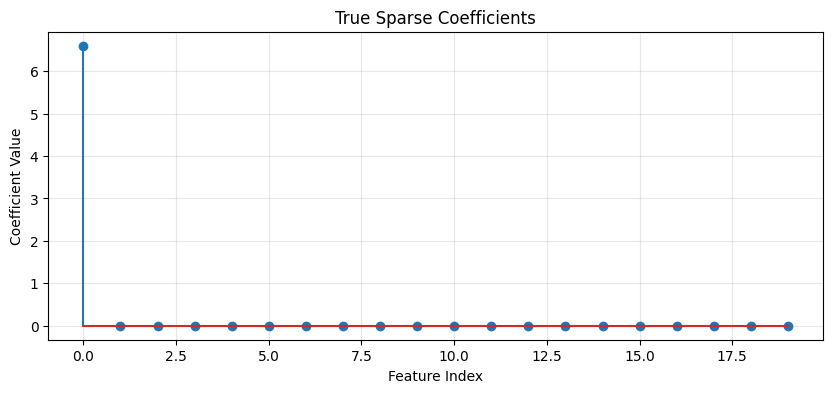

Initializing NUTS using jitter+adapt_diag...


Fitting Horseshoe model...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lambdas, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
There were 1799 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Fitting Spike-and-Slab model...


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, sigma_beta, beta_raw, sigma]
>BinaryGibbsMetropolis: [gamma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
/Users/yiru/Library/Python/3.12/lib/python/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 130 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


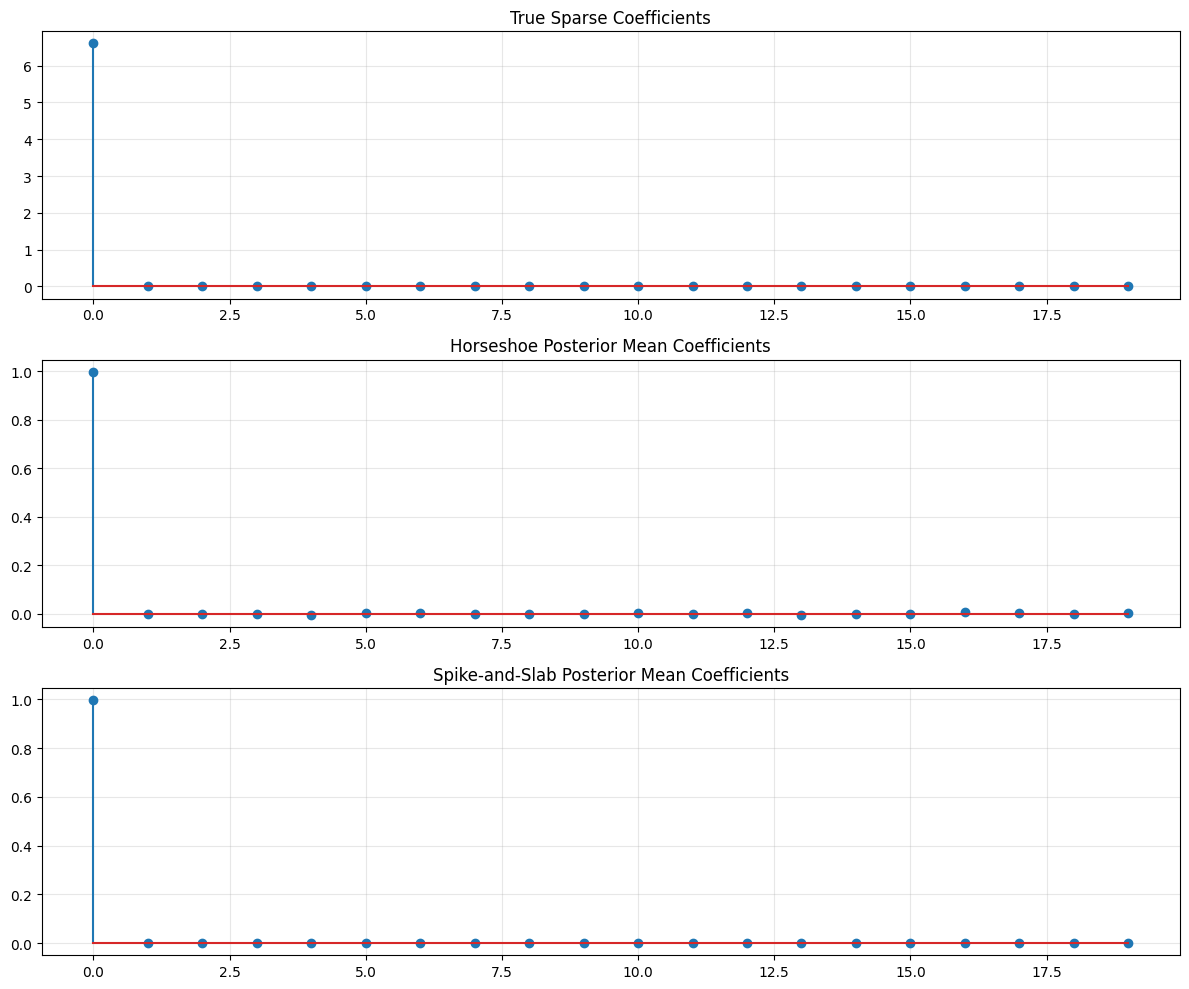


Comparison of methods:
    True Coefficient  Horseshoe Mean  Spike-Slab Mean  \
0              6.601           0.998            0.997   
1              0.000           0.000            0.000   
2              0.000          -0.000           -0.000   
3              0.000          -0.000            0.000   
4              0.000          -0.004           -0.000   
5              0.000           0.002            0.000   
6              0.000           0.001            0.000   
7              0.000          -0.002           -0.000   
8              0.000          -0.001           -0.000   
9              0.000          -0.000           -0.000   
10             0.000           0.004            0.000   
11             0.000           0.001            0.000   
12             0.000           0.004            0.000   
13             0.000          -0.004           -0.000   
14             0.000          -0.001           -0.000   
15             0.000          -0.001           -0.000   
16     

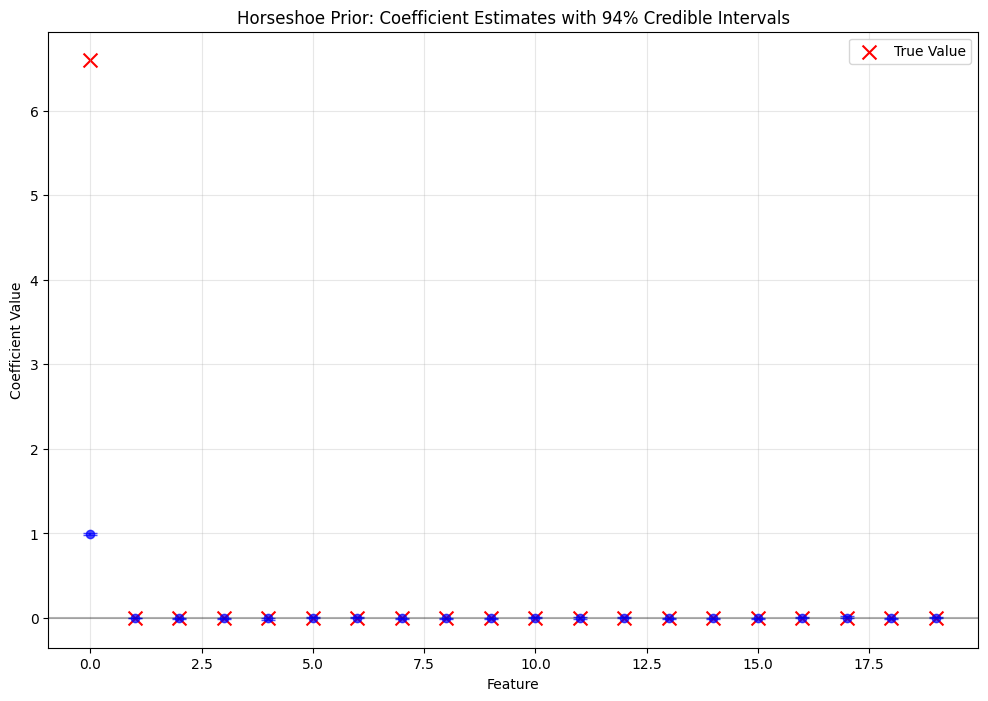

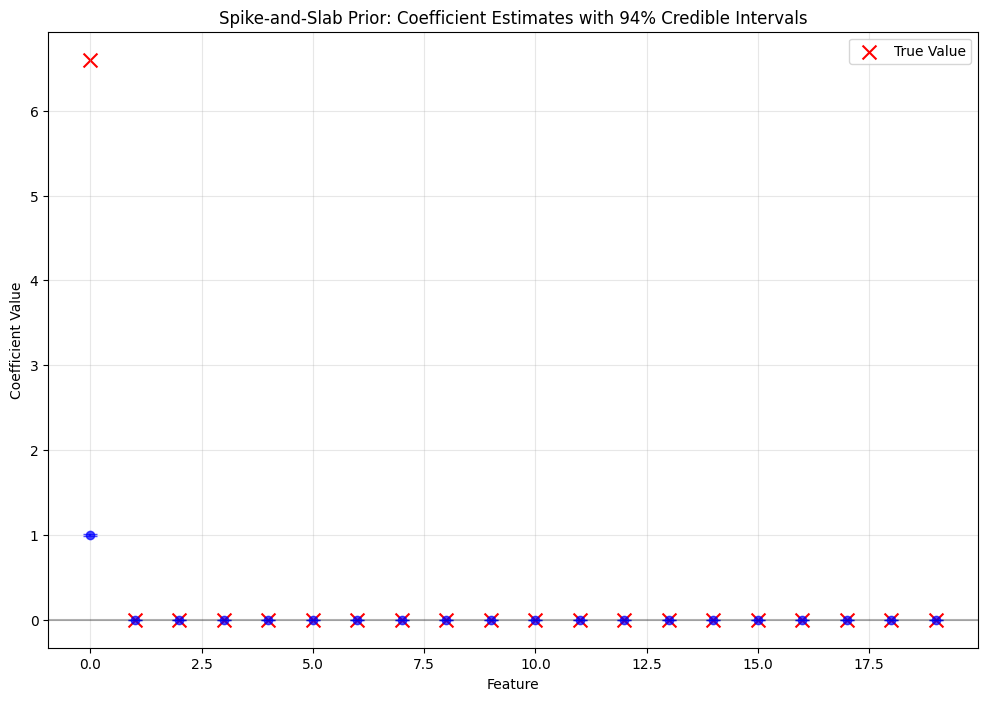

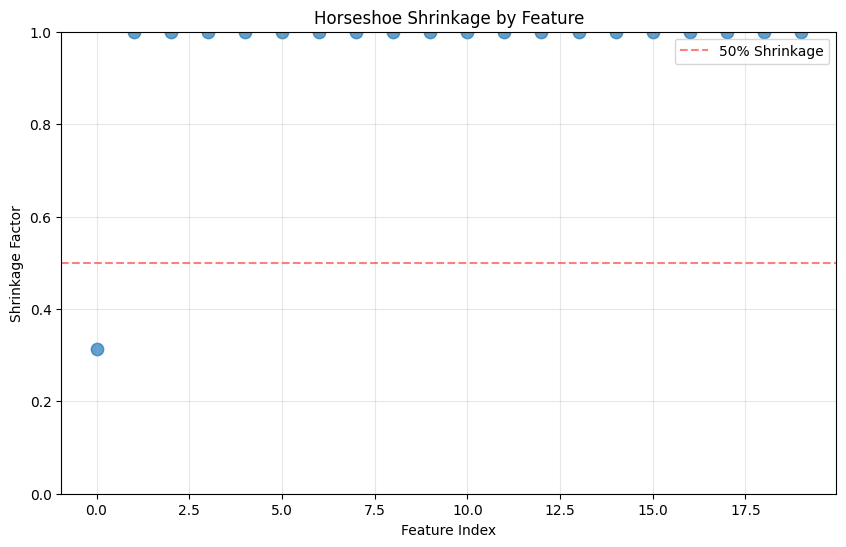

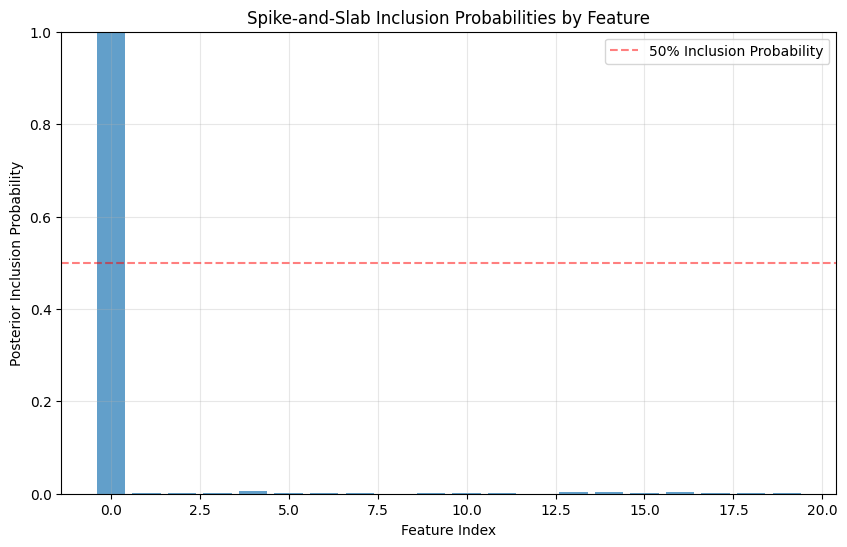

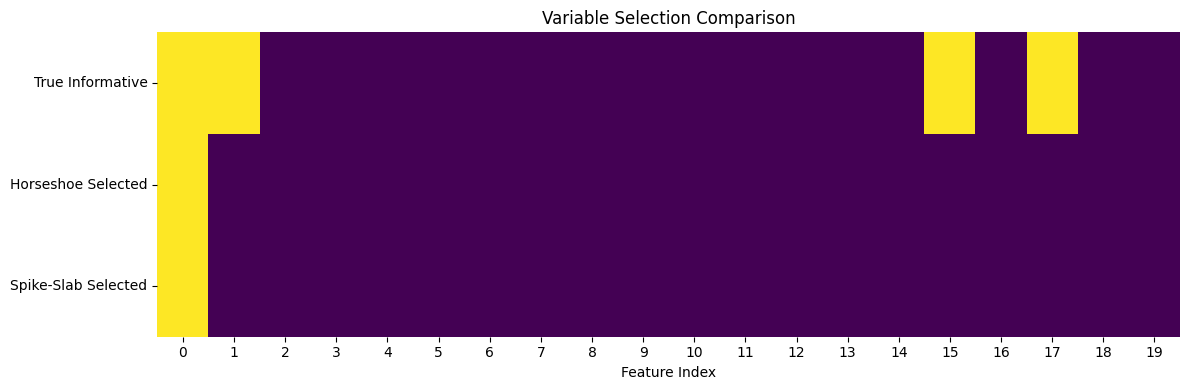


SUMMARY OF FINDINGS:
--------------------------------------------------
1. Model Accuracy:
   - Horseshoe MSE: 1.5696
   - Spike-and-Slab MSE: 1.5704

2. Variable Selection Performance:
   - Horseshoe True Positive Rate: 1.0000
   - Spike-and-Slab True Positive Rate: 1.0000
   - Horseshoe False Positive Rate: 0.0000
   - Spike-and-Slab False Positive Rate: 0.0000

3. Sparsity Induced:
   - Horseshoe Sparsity: 0.9500
   - Spike-and-Slab Sparsity: 0.9500

4. Overall Variable Selection Accuracy:
   - Horseshoe: 1.0000
   - Spike-and-Slab: 1.0000
--------------------------------------------------

COMPARISON OF METHODS:
--------------------------------------------------
Horseshoe Prior:
Advantages:
- Continuous shrinkage (no hard thresholding)
- Adaptive shrinkage based on coefficient magnitude
- Good at handling many weak signals
- Simple implementation with fewer hyperparameters

Disadvantages:
- May not fully zero out coefficients
- No explicit posterior probability of inclusion
- Inte

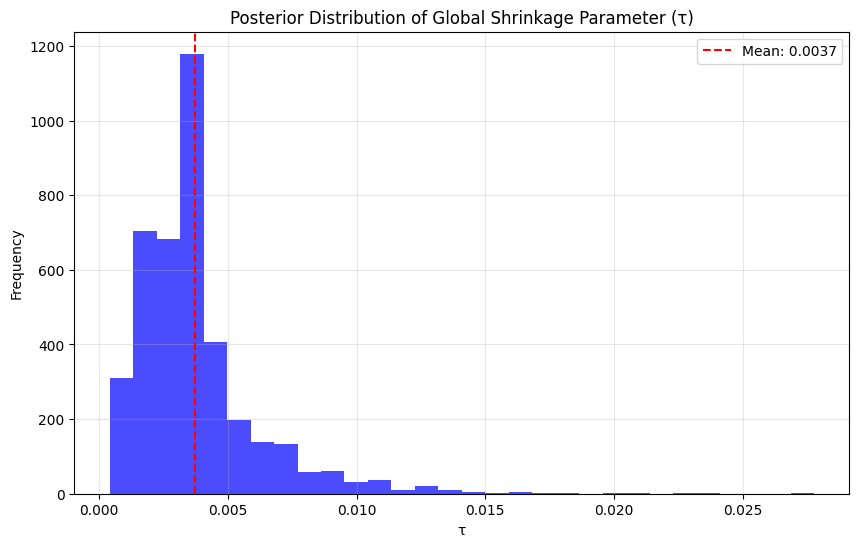

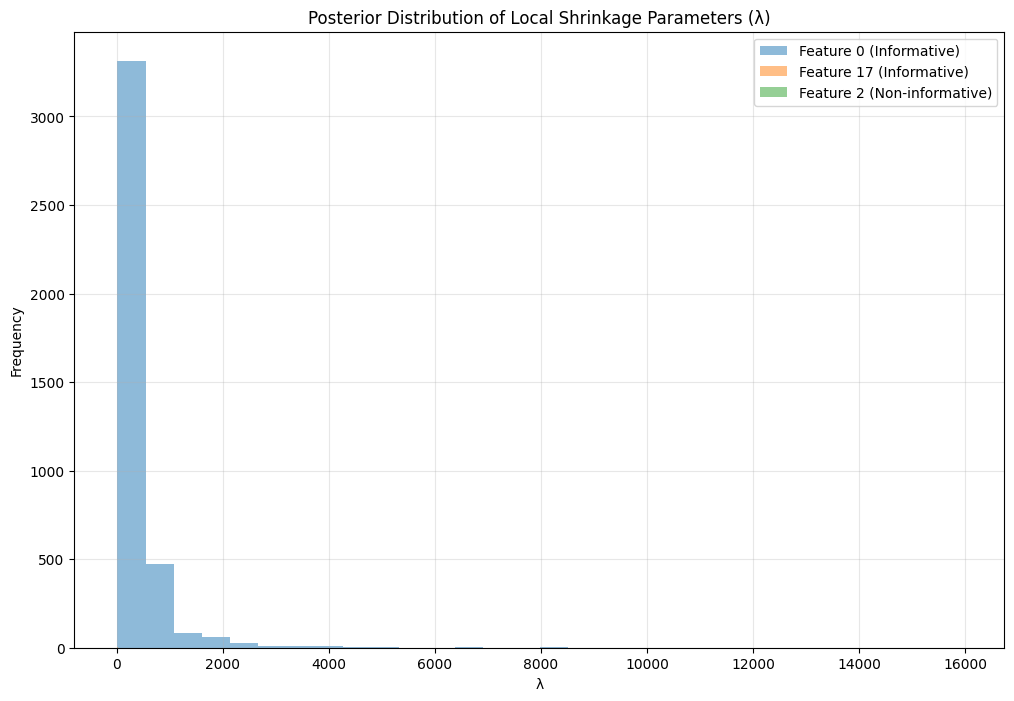

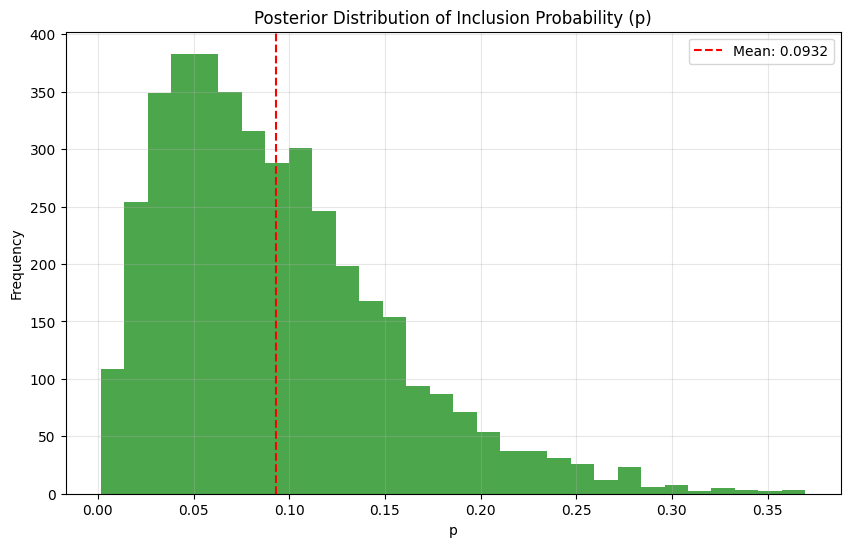

AttributeError: module 'matplotlib.pyplot' has no attribute 'open'

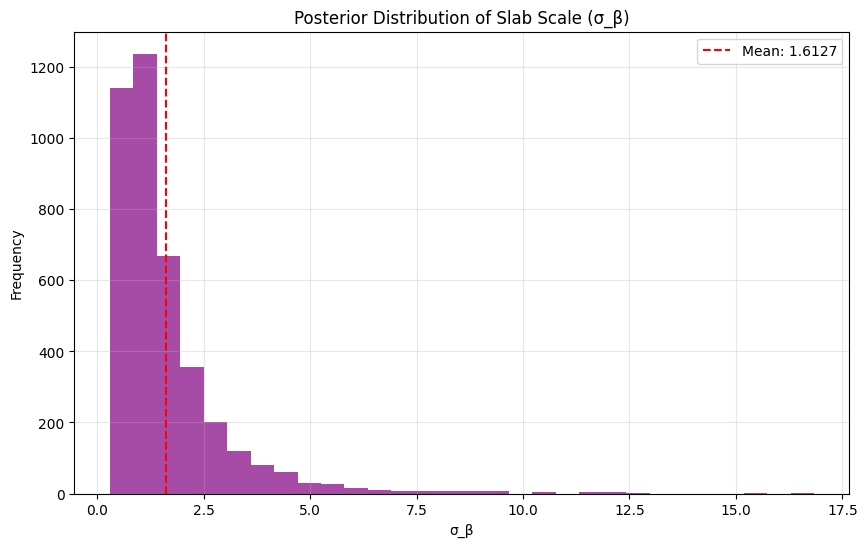

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from sklearn.datasets import make_regression
import pandas as pd
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data with known sparse structure
n_samples = 100
n_features = 20
n_informative = 4  # Only 4 features are truly informative

# Create regression data with sparse coefficients
X, y, true_coefs = make_regression(
    n_samples=n_samples, 
    n_features=n_features,
    n_informative=n_informative,
    noise=0.5,
    coef=True,
    random_state=42
)

# Scale X and y for numerical stability
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
y_scaled = (y - y.mean()) / y.std()

# Make most coefficients exactly zero to create true sparsity
true_sparse_coefs = np.zeros(n_features)
# Put non-zero values in random positions
informative_idx = np.random.choice(n_features, n_informative, replace=False)
true_sparse_coefs[informative_idx] = true_coefs[informative_idx]

# Generate data with the sparse coefficients
y_sparse = X_scaled @ true_sparse_coefs + np.random.normal(0, 0.5, n_samples)
y_sparse = (y_sparse - y_sparse.mean()) / y_sparse.std()

# Print the true sparse coefficients
print("True sparse coefficients:")
print(true_sparse_coefs)
print(f"Number of non-zero coefficients: {np.sum(np.abs(true_sparse_coefs) > 0)}")
print(f"Indices of informative features: {informative_idx}")

# Visualize the true sparse coefficients
plt.figure(figsize=(10, 4))
plt.stem(range(n_features), true_sparse_coefs)
plt.title("True Sparse Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
plt.grid(True, alpha=0.3)
plt.show()

# Function to create and fit a Horseshoe prior model
def fit_horseshoe_model(X, y, n_samples=1000):
    with pm.Model() as horseshoe_model:
        # Global shrinkage parameter
        tau = pm.HalfCauchy('tau', beta=1)
        
        # Local shrinkage parameters
        lambdas = pm.HalfCauchy('lambdas', beta=1, shape=X.shape[1])
        
        # Calculate the shrinkage factor
        c = tau * lambdas
        
        # Regression weights with horseshoe prior
        beta = pm.Normal('beta', mu=0, sigma=c, shape=X.shape[1])
        
        # Model error
        sigma = pm.HalfCauchy('sigma', beta=1)
        
        # Expected value
        mu = pm.Deterministic('mu', pm.math.dot(X, beta))
        
        # Likelihood
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
        
        # Sample from the posterior
        trace = pm.sample(n_samples, tune=1000, return_inferencedata=True)
    
    return horseshoe_model, trace

# Function to create and fit a Spike-and-Slab prior model
def fit_spike_and_slab_model(X, y, n_samples=1000):
    with pm.Model() as spike_slab_model:
        # Spike and slab prior parameters
        # Probability of inclusion (spike or slab)
        p = pm.Beta('p', alpha=1, beta=1)
        
        # Inclusion indicators (0 = spike, 1 = slab)
        gamma = pm.Bernoulli('gamma', p=p, shape=X.shape[1])
        
        # Scale for the slab part
        sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
        
        # Regression weights with spike and slab prior
        beta_raw = pm.Normal('beta_raw', mu=0, sigma=sigma_beta, shape=X.shape[1])
        beta = pm.Deterministic('beta', beta_raw * gamma)
        
        # Model error
        sigma = pm.HalfCauchy('sigma', beta=1)
        
        # Expected value
        mu = pm.Deterministic('mu', pm.math.dot(X, beta))
        
        # Likelihood
        likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
        
        # Sample from the posterior
        trace = pm.sample(n_samples, tune=1000, return_inferencedata=True)
    
    return spike_slab_model, trace

# Fit both models
print("Fitting Horseshoe model...")
horseshoe_model, horseshoe_trace = fit_horseshoe_model(X_scaled, y_sparse, n_samples=1000)

print("Fitting Spike-and-Slab model...")
spike_slab_model, spike_slab_trace = fit_spike_and_slab_model(X_scaled, y_sparse, n_samples=1000)

# Extract posterior samples
horseshoe_betas = horseshoe_trace.posterior['beta'].values
spike_slab_betas = spike_slab_trace.posterior['beta'].values

# Calculate posterior means
horseshoe_beta_means = horseshoe_betas.mean(axis=(0, 1))
spike_slab_beta_means = spike_slab_betas.mean(axis=(0, 1))

# Calculate posterior probabilities of inclusion for the spike-and-slab model
spike_slab_inclusion = spike_slab_trace.posterior['gamma'].values.mean(axis=(0, 1))

# Visualize the results
plt.figure(figsize=(12, 10))

# True coefficients
plt.subplot(3, 1, 1)
plt.stem(range(n_features), true_sparse_coefs)
plt.title("True Sparse Coefficients")
plt.grid(True, alpha=0.3)

# Horseshoe posterior means
plt.subplot(3, 1, 2)
plt.stem(range(n_features), horseshoe_beta_means)
plt.title("Horseshoe Posterior Mean Coefficients")
plt.grid(True, alpha=0.3)

# Spike-and-Slab posterior means
plt.subplot(3, 1, 3)
plt.stem(range(n_features), spike_slab_beta_means)
plt.title("Spike-and-Slab Posterior Mean Coefficients")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a comparison table
comparison_data = {
    'True Coefficient': true_sparse_coefs,
    'Horseshoe Mean': horseshoe_beta_means,
    'Spike-Slab Mean': spike_slab_beta_means,
    'Spike-Slab Inclusion Prob': spike_slab_inclusion
}
comparison_df = pd.DataFrame(comparison_data)

# Calculate shrinkage for horseshoe
horseshoe_tau = horseshoe_trace.posterior['tau'].values.mean()
horseshoe_lambdas = horseshoe_trace.posterior['lambdas'].values.mean(axis=(0, 1))
horseshoe_shrinkage = 1 / (1 + horseshoe_tau**2 * horseshoe_lambdas**2)

comparison_df['Horseshoe Shrinkage'] = horseshoe_shrinkage

# Add a column to indicate if the feature is truly informative
comparison_df['Is Informative'] = [i in informative_idx for i in range(n_features)]

# Print the comparison table
print("\nComparison of methods:")
print(comparison_df.round(3))

# Calculate performance metrics
def calculate_metrics(true_coefs, estimated_coefs, threshold=0.05):
    # Set small coefficients to zero
    estimated_sparse = np.where(np.abs(estimated_coefs) < threshold, 0, estimated_coefs)
    
    # Calculate Mean Squared Error
    mse = np.mean((true_coefs - estimated_coefs)**2)
    
    # Calculate sparsity (percentage of zero coefficients)
    sparsity = np.sum(estimated_sparse == 0) / len(estimated_sparse)
    
    # Calculate true positive rate (detecting non-zero coefficients correctly)
    true_nonzero = np.abs(true_coefs) > 0
    pred_nonzero = np.abs(estimated_sparse) > 0
    true_positives = np.sum(true_nonzero & pred_nonzero)
    
    if np.sum(true_nonzero) > 0:
        tpr = true_positives / np.sum(true_nonzero)
    else:
        tpr = 0
    
    # Calculate false positive rate
    true_zero = ~true_nonzero
    pred_nonzero = np.abs(estimated_sparse) > 0
    false_positives = np.sum(true_zero & pred_nonzero)
    
    if np.sum(true_zero) > 0:
        fpr = false_positives / np.sum(true_zero)
    else:
        fpr = 0
    
    return {
        'MSE': mse,
        'Sparsity': sparsity,
        'True Positive Rate': tpr,
        'False Positive Rate': fpr,
        'Variable Selection Accuracy': (true_positives + np.sum(true_zero & ~pred_nonzero)) / len(true_coefs)
    }

# Calculate metrics for both methods
horseshoe_metrics = calculate_metrics(true_sparse_coefs, horseshoe_beta_means)
spike_slab_metrics = calculate_metrics(true_sparse_coefs, spike_slab_beta_means)

# Print metrics
print("\nPerformance Metrics:")
print("Horseshoe Model:")
for k, v in horseshoe_metrics.items():
    print(f"{k}: {v:.4f}")
    
print("\nSpike-and-Slab Model:")
for k, v in spike_slab_metrics.items():
    print(f"{k}: {v:.4f}")

# Visualize coefficient distributions
def plot_credible_intervals(trace, var_name='beta', true_values=None, title=''):
    """Plot the posterior distribution and credible intervals for each coefficient"""
    summary = az.summary(trace, var_names=[var_name])
    
    # Extract relevant data
    mean = summary['mean'].values
    hdi_3 = summary['hdi_3%'].values
    hdi_97 = summary['hdi_97%'].values
    
    # Create a DataFrame for plotting
    df = pd.DataFrame({
        'Feature': range(len(mean)),
        'Mean': mean,
        'Lower': hdi_3,
        'Upper': hdi_97
    })
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.errorbar(df['Feature'], df['Mean'], yerr=[df['Mean'] - df['Lower'], df['Upper'] - df['Mean']], 
                fmt='o', capsize=5, color='blue', alpha=0.7)
    
    if true_values is not None:
        plt.scatter(range(len(true_values)), true_values, color='red', marker='x', s=100, label='True Value')
    
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    return plt

# Plot credible intervals for both models
horseshoe_plot = plot_credible_intervals(horseshoe_trace, 'beta', true_sparse_coefs, 
                                         'Horseshoe Prior: Coefficient Estimates with 94% Credible Intervals')
horseshoe_plot.savefig("horseshoe_credible_intervals.png")
plt.show()

spike_slab_plot = plot_credible_intervals(spike_slab_trace, 'beta', true_sparse_coefs, 
                                          'Spike-and-Slab Prior: Coefficient Estimates with 94% Credible Intervals')
spike_slab_plot.savefig("spike_slab_credible_intervals.png")
plt.show()

# Plot the shrinkage pattern of the horseshoe prior
plt.figure(figsize=(10, 6))
plt.scatter(range(n_features), horseshoe_shrinkage, s=80, alpha=0.7)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% Shrinkage')
plt.title('Horseshoe Shrinkage by Feature')
plt.xlabel('Feature Index')
plt.ylabel('Shrinkage Factor')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.legend()
plt.savefig("horseshoe_shrinkage.png")
plt.show()

# Plot inclusion probabilities for spike-and-slab
plt.figure(figsize=(10, 6))
plt.bar(range(n_features), spike_slab_inclusion, alpha=0.7)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% Inclusion Probability')
plt.title('Spike-and-Slab Inclusion Probabilities by Feature')
plt.xlabel('Feature Index')
plt.ylabel('Posterior Inclusion Probability')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.legend()
plt.savefig("spike_slab_inclusion.png")
plt.show()

# Compare variable selection with a heatmap
selection_data = pd.DataFrame({
    'Feature': range(n_features),
    'True Informative': [i in informative_idx for i in range(n_features)],
    'Horseshoe Selected': np.abs(horseshoe_beta_means) > 0.05,
    'Spike-Slab Selected': np.abs(spike_slab_beta_means) > 0.05,
})

# Create a binary matrix for the heatmap
heatmap_data = selection_data.iloc[:, 1:].astype(int).T

plt.figure(figsize=(12, 4))
sns.heatmap(heatmap_data, cmap='viridis', cbar=False, 
            xticklabels=selection_data['Feature'],
            yticklabels=['True Informative', 'Horseshoe Selected', 'Spike-Slab Selected'])
plt.title('Variable Selection Comparison')
plt.xlabel('Feature Index')
plt.tight_layout()
plt.savefig("selection_comparison_heatmap.png")
plt.show()

# Summarize the key findings
print("\nSUMMARY OF FINDINGS:")
print("-" * 50)
print("1. Model Accuracy:")
print(f"   - Horseshoe MSE: {horseshoe_metrics['MSE']:.4f}")
print(f"   - Spike-and-Slab MSE: {spike_slab_metrics['MSE']:.4f}")
print("\n2. Variable Selection Performance:")
print(f"   - Horseshoe True Positive Rate: {horseshoe_metrics['True Positive Rate']:.4f}")
print(f"   - Spike-and-Slab True Positive Rate: {spike_slab_metrics['True Positive Rate']:.4f}")
print(f"   - Horseshoe False Positive Rate: {horseshoe_metrics['False Positive Rate']:.4f}")
print(f"   - Spike-and-Slab False Positive Rate: {spike_slab_metrics['False Positive Rate']:.4f}")
print("\n3. Sparsity Induced:")
print(f"   - Horseshoe Sparsity: {horseshoe_metrics['Sparsity']:.4f}")
print(f"   - Spike-and-Slab Sparsity: {spike_slab_metrics['Sparsity']:.4f}")
print("\n4. Overall Variable Selection Accuracy:")
print(f"   - Horseshoe: {horseshoe_metrics['Variable Selection Accuracy']:.4f}")
print(f"   - Spike-and-Slab: {spike_slab_metrics['Variable Selection Accuracy']:.4f}")
print("-" * 50)

# Compare the advantages and disadvantages
print("\nCOMPARISON OF METHODS:")
print("-" * 50)
print("Horseshoe Prior:")
print("Advantages:")
print("- Continuous shrinkage (no hard thresholding)")
print("- Adaptive shrinkage based on coefficient magnitude")
print("- Good at handling many weak signals")
print("- Simple implementation with fewer hyperparameters")
print("\nDisadvantages:")
print("- May not fully zero out coefficients")
print("- No explicit posterior probability of inclusion")
print("- Interpretation less straightforward")

print("\nSpike-and-Slab Prior:")
print("Advantages:")
print("- Explicit variable selection mechanism")
print("- Provides direct posterior probability of inclusion")
print("- Can achieve exact zeros for coefficients")
print("- More interpretable selection decisions")
print("\nDisadvantages:")
print("- More complex implementation")
print("- May require more samples to converge")
print("- Discrete nature can lead to multimodal posteriors")
print("-" * 50)

# Analyze the horseshoe posterior
horseshoe_tau_posterior = horseshoe_trace.posterior['tau'].values.flatten()
horseshoe_lambda_posterior = horseshoe_trace.posterior['lambdas'].values

# Plot the global shrinkage parameter
plt.figure(figsize=(10, 6))
plt.hist(horseshoe_tau_posterior, bins=30, alpha=0.7, color='blue')
plt.axvline(horseshoe_tau_posterior.mean(), color='r', linestyle='--', 
            label=f'Mean: {horseshoe_tau_posterior.mean():.4f}')
plt.title('Posterior Distribution of Global Shrinkage Parameter (τ)')
plt.xlabel('τ')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("horseshoe_tau_posterior.png")
plt.show()

# Plot local shrinkage parameters for a few features
plt.figure(figsize=(12, 8))
for i in informative_idx[:2]:  # Plot for a couple of informative features
    plt.hist(horseshoe_lambda_posterior[:, :, i].flatten(), bins=30, alpha=0.5, 
             label=f'Feature {i} (Informative)')

for i in range(n_features):
    if i not in informative_idx:
        plt.hist(horseshoe_lambda_posterior[:, :, i].flatten(), bins=30, alpha=0.5, 
                 label=f'Feature {i} (Non-informative)')
        break

plt.title('Posterior Distribution of Local Shrinkage Parameters (λ)')
plt.xlabel('λ')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("horseshoe_lambda_posterior.png")
plt.show()

# Plot spike-and-slab posterior
spike_slab_p_posterior = spike_slab_trace.posterior['p'].values.flatten()
spike_slab_sigma_beta_posterior = spike_slab_trace.posterior['sigma_beta'].values.flatten()

plt.figure(figsize=(10, 6))
plt.hist(spike_slab_p_posterior, bins=30, alpha=0.7, color='green')
plt.axvline(spike_slab_p_posterior.mean(), color='r', linestyle='--', 
            label=f'Mean: {spike_slab_p_posterior.mean():.4f}')
plt.title('Posterior Distribution of Inclusion Probability (p)')
plt.xlabel('p')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("spike_slab_p_posterior.png")
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(spike_slab_sigma_beta_posterior, bins=30, alpha=0.7, color='purple')
plt.axvline(spike_slab_sigma_beta_posterior.mean(), color='r', linestyle='--', 
            label=f'Mean: {spike_slab_sigma_beta_posterior.mean():.4f}')
plt.title('Posterior Distribution of Slab Scale (σ_β)')
plt.xlabel('σ_β')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.open()

print("\nCONCLUSION:")
print("-" * 50)
if horseshoe_metrics['Variable Selection Accuracy'] > spike_slab_metrics['Variable Selection Accuracy']:
    print("The Horseshoe prior demonstrated superior variable selection accuracy in this example.")
elif horseshoe_metrics['Variable Selection Accuracy'] < spike_slab_metrics['Variable Selection Accuracy']:
    print("The Spike-and-Slab prior demonstrated superior variable selection accuracy in this example.")
else:
    print("Both priors performed equally well in terms of variable selection accuracy.")

print("\nIn practice, the choice between these methods depends on the specific goals:")
print("- Use Horseshoe when you want more continuous shrinkage and have many potential weak signals.")
print("- Use Spike-and-Slab when you need explicit variable selection with inclusion probabilities.")
print("- Consider computational resources, as Spike-and-Slab may require more sampling.")
print("-" * 50)